In [18]:

import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy import signal
from scipy import linalg 

import mne

# Global variables
sampling_rate = 250


In [19]:
"""Extracting data for 8 channel data"""
# Function to read files, put data in lists, returns an array with 8 entries, each one being a list of all values for a channel
def extract_channel_vals_8_channels(data_file_path):
    
    data_file = open(data_file_path, 'r')
    
    channel_vals = [ [], [], [], [], [], [], [], [] ]
    
    for line in data_file:

        temp = line.strip().split(",")
        
        try:
            for i in range(len(channel_vals)):
                
                # Need to skip first column of text file since it has sample index info
                channel_vals[i].append(float(temp[i + 1]))

        except:
            pass  
    
    data_file.close()
        
    # Convert lists to arrays
    for channel_vals_i in [channel_vals[0], channel_vals[1], channel_vals[2], channel_vals[3],
                         channel_vals[4], channel_vals[5], channel_vals[6], channel_vals[7], ]:
        channel_vals_i = np.array(channel_vals_i)
    

    
    channel_vals = np.array(channel_vals)
    
    return channel_vals

In [20]:
subject_1_data_1_path = r'C:\Users\alexm\OneDrive\Computer Files\EEG\Recordings\OpenBCISession_2021-10-16_15-40-46_Subject1_Protocol1\OpenBCI-RAW-2021-10-16_15-42-09.txt'
subject_2_data_1_path = r'C:\Users\alexm\OneDrive\Computer Files\EEG\Recordings\OpenBCISession_2021-10-16_15-08-43_Subject2_Protocol1\OpenBCI-RAW-2021-10-16_15-10-34.txt'
subject_4_data_1_path = r'C:\Users\alexm\OneDrive\Computer Files\EEG\Recordings\OpenBCISession_2021-10-16_14-51-59_Subject4_Protocol1\OpenBCI-RAW-2021-10-16_14-55-24.txt'

In [21]:
# Create EEG vector for a single 2s epoch

"""
Plan to get final input vector X for CSP:
    1. Split channel values into 2s epochs (3s to 15s, 15s to 27s, 33s - 45s, 45-57s, all have 6 2-second epochs)
    2. Filter channel values into alpha range
    3. Create matrix x for each epoch (8 x 500 for 8 channels, 500 samples (2 * sampling rate))
    4. Create vectors X (open) and X (closed) for training open and training closed data using specific epochs for those
    5. X vectors are input vectors for CSP
"""
def get_epoch_vector(channel_vals, start_time):
    
    sampling_rate = 250
    
    low_filter = 5 #Hz
    high_filter = 15 #Hz
    b, a = signal.butter(5, [low_filter/250, high_filter/250], "bandpass")
    
    counter = start_time
    
    # Use bandpass filter to filter all channels into alpha range (5-15 Hz)
    channel_vals_filtered = channel_vals[:]
    for i in range (8):
        channel_vals_filtered[i] = signal.filtfilt(b, a, channel_vals[i])

    # Create (8 x 500) matrix x for a 2s epoch
    
    epoch_vector = [[], [], [], [], [], [], [], []]
    for i in range(8):
        for j in range(counter * sampling_rate, (counter + 2) * sampling_rate):
            epoch_vector[i].append(channel_vals_filtered[i][j])

    epoch_vector = np.array(epoch_vector)

    #print(np.shape(epoch_vector))
    
    return epoch_vector

In [22]:
get_epoch_vector(extract_channel_vals_8_channels(subject_2_data_1_path), 3)

array([[  0.3864041 ,   0.2295811 ,   0.0201083 , ...,  -1.16368571,
         -1.13146769,  -1.04755202],
       [  1.68812418,   1.85687377,   1.94361284, ...,   1.05981832,
          1.17026009,   1.32054448],
       [  7.38416936,   7.03543841,   6.50276352, ...,   0.17002761,
         -0.08521103,  -0.31383634],
       ...,
       [  0.02979931,   0.61357367,   1.24680734, ..., -14.01227113,
        -11.31223022,  -8.64491534],
       [ 10.90559444,  10.33550158,   9.68655769, ...,   4.42235084,
          5.12657918,   5.70372474],
       [  5.45667503,   5.31630237,   5.06418622, ...,  -2.03590526,
         -2.60942343,  -3.13268406]])

In [23]:
# Create input vector for CSP, X consisting of start time and next 12 seconds, split into 6 2-second epochs

def get_input_vector(channel_vals, start_time):
    
    csp_vector = []
    
    for epoch in range(start_time, start_time + 12, 2):
        csp_vector.append(get_epoch_vector(channel_vals, epoch))
        
    for epoch in range(start_time + 30, start_time + 42, 2):
        csp_vector.append(get_epoch_vector(channel_vals, epoch))
    
    csp_vector = np.array(csp_vector)
    
    #print(np.shape(csp_vector))
    
    return csp_vector
    

In [24]:
#get_input_vector(extract_channel_vals_8_channels(subject_2_data_1_path), 3)

In [25]:
# Return all 4 input vectors for CSP - eyes open training, eyes closed training, eyes open testing, eyes open testing

def get_all_input_vectors(channel_vals):
    
    eyes_open_training = get_input_vector(extract_channel_vals_8_channels(subject_2_data_1_path), 3)
    eyes_closed_training = get_input_vector(extract_channel_vals_8_channels(subject_2_data_1_path), 33)
    eyes_open_testing = get_input_vector(extract_channel_vals_8_channels(subject_2_data_1_path), 15)
    eyes_closed_testing = get_input_vector(extract_channel_vals_8_channels(subject_2_data_1_path), 45)
    
    return eyes_open_training, eyes_closed_training, eyes_open_testing, eyes_closed_testing
    
    

In [35]:
training = get_input_vector(extract_channel_vals_8_channels(subject_2_data_1_path), 3)
testing = get_input_vector(extract_channel_vals_8_channels(subject_2_data_1_path), 15)
print(np.shape(training), np.shape(testing))
labels = np.array([1,1,1,1,1,1,2,2,2,2,2,2])
csp = mne.decoding.CSP(n_components=4, norm_trace=False)
training_x = csp.fit_transform(training, labels)
testing_x = csp.fit_transform(testing, labels)
print(training_x)

(12, 8, 500) (12, 8, 500)
Computing rank from data with rank=None
    Using tolerance 1.2 (2.2e-16 eps * 8 dim * 7e+14  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.5 (2.2e-16 eps * 8 dim * 8.6e+14  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.1 (2.2e-16 eps * 8 dim * 6.2e+14  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1 (2.2e-16 eps * 8 dim * 5.9e+14  max singular value)
    Estimated

In [36]:
from sklearn import svm

train_y = [0,0,0,0,0,0,1,1,1,1,1,1]

clf_svm = svm.SVC(kernel = 'linear')
clf_svm.fit(training_x, train_y)

print(clf_svm.score(testing_x, train_y))

0.5


In [37]:
channel_names = ["Fp1", "Fp2", "C3", "C4", "O1", "O2", "P4", "P3"]
info = mne.create_info(channel_names, sampling_rate, "eeg")
info.set_montage("standard_alphabetic")


<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fp2, C3, C4, O1, O2, P4, P3
 chs: 8 EEG
 custom_ref_applied: False
 dig: 11 items (3 Cardinal, 8 EEG)
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: unspecified
 nchan: 8
 projs: []
 sfreq: 250.0 Hz
>

Computing rank from data with rank=None
    Using tolerance 1.2 (2.2e-16 eps * 8 dim * 7e+14  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.5 (2.2e-16 eps * 8 dim * 8.6e+14  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.


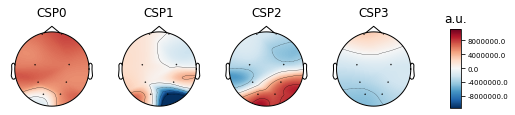

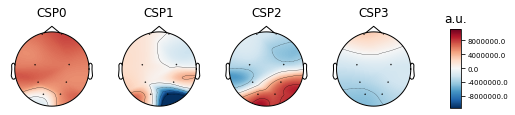

In [38]:
csp.fit(training, labels)
csp.plot_patterns(info)

In [39]:
# Look at energy spectrum of fit_transform outputs (CSP2 should be distinct from other ones)
# Try CSP on data that is only filtered 0-60 hz, not into alpha band

In [40]:
[csp_1, csp_2, csp_3, csp_4, csp_5, csp_6, csp_7, csp_8, csp_9, csp_10, csp_11, csp_12] = csp.fit_transform(training, labels)

Computing rank from data with rank=None
    Using tolerance 1.2 (2.2e-16 eps * 8 dim * 7e+14  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.5 (2.2e-16 eps * 8 dim * 8.6e+14  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.


In [41]:
print (csp_1)

[-1.85806348 -0.01658714 -0.00360987 -1.05976644]
